In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import sklearn 
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt # рисовать графики
pd.options.mode.chained_assignment = None

In [2]:
df_anime = pd.read_csv('anime_filtered.csv')
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14474 entries, 0 to 14473
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   anime_id        14474 non-null  int64  
 1   title           14474 non-null  object 
 2   title_english   5723 non-null   object 
 3   title_japanese  14440 non-null  object 
 4   title_synonyms  8936 non-null   object 
 5   image_url       14378 non-null  object 
 6   type            14474 non-null  object 
 7   source          14474 non-null  object 
 8   episodes        14474 non-null  int64  
 9   status          14474 non-null  object 
 10  airing          14474 non-null  bool   
 11  aired_string    14474 non-null  object 
 12  aired           14474 non-null  object 
 13  duration        14474 non-null  object 
 14  rating          13932 non-null  object 
 15  score           14474 non-null  float64
 16  scored_by       14474 non-null  int64  
 17  rank            12901 non-null 

### Which variable did you choose as the target when building the regression model?


I decided to choose score as the target variable based on the scope of the main task. Let's try to build a regression model with several variables. To begin with, let's remove observations with a zero value of the target variable, since they are outliers:

In [3]:
df = df_anime[df_anime.score > 0]

As predictors, I decided not to take variables that have a lot of null values in the source table. Therefore, variables such as background or licensor will not be used. In addition, some variables obviously will not help to build a model, since they are unique for each title - for example, the name of the anime, image_url or the theme from the opening/ending. I may be able to parse the themes by artist, but I have a feeling that this will also have little effect on anything.

First, let's create a separate dataframe with the necessary numeric variables, and also make dummy variables for the object type, which, it seems to me, will have a statistical significant impact on the model.

In [182]:
df_cleaned = df[['score', 'type', 'source', 'rating', 'episodes', 'scored_by', 'members', 'favorites', 'genre']]

Converting genres to dummy variables:

In [183]:
df_cleaned['genres'] = df_cleaned.genre.str.split(pat=", ")
genres = df_cleaned['genres']
genres_dummy = pd.get_dummies(genres.explode()).groupby(level=0).sum()

Converting other variables:

In [184]:
df_cleaned['type'] = df_cleaned['type'].astype('category')
df_cleaned['source'] = df_cleaned['source'].astype('category')
df_cleaned['rating'] = df_cleaned['rating'].astype('category')

Let's combine everything into one dataframe:

In [185]:
df_result = pd.concat([df_cleaned, genres_dummy], axis=1)

In [188]:
df_result.head(3)

,score,type,source,rating,episodes,scored_by,members,favorites,genre,genres,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,7.63,TV,Manga,PG-13 - Teens 13 or older,12,139250,283882,2809,"Comedy, Supernatural, Romance, Shounen","[Comedy, Supernatural, Romance, Shounen]",...,0,0,0,0,0,1,0,0,0,0
1,7.89,TV,Manga,PG-13 - Teens 13 or older,26,91206,204003,2579,"Comedy, Parody, Romance, School, Shounen","[Comedy, Parody, Romance, School, Shounen]",...,0,0,0,0,0,0,0,0,0,0
2,7.55,TV,Manga,PG - Children,51,37129,70127,802,"Comedy, Magic, School, Shoujo","[Comedy, Magic, School, Shoujo]",...,0,0,0,0,0,0,0,0,0,0


Let's remove the interfering signs in the names of variables for the correct operation of ols:

In [189]:
df_result.columns = df_result.columns.str.replace(' ', '_') 
df_result.columns = df_result.columns.str.replace('-', '_') 

There are a lot of predictors. For convenience, let's remove unnecessary columns:

In [191]:
all_columns = "+".join(df_result.columns.difference(['score', 'genre', 'genres']))
my_formula = 'score~' + all_columns

In [192]:
res = smf.ols(formula=my_formula, data = df_result).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     166.3
Date:                Thu, 30 Nov 2023   Prob (F-statistic):               0.00
Time:                        21:06:41   Log-Likelihood:                -16639.
No. Observations:               13767   AIC:                         3.342e+04
Df Residuals:                   13694   BIC:                         3.397e+04
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    5.9823      0.065     92.488      0.000       5.855       6.109
rating[T.PG - Children]                      0.1882      0.027      6.880      0.000       0.135       0.242
rating[T.PG-13 - Teens 13 or older]          0.3888      0.022     18.049      0.000       0.347       0.431
rating[T.R - 17+ (violence & profanity)]     0.3618      0.036      9.989      0.000       0.291       0.433
rating[T.R+ - Mild Nudity]                   0.1727      0.039      4.461      0.000       0.097       0.249
rating[T.Rx - Hentai]                       -0.5857      0.814     -0.720      0.472      -2.181       1.010
source[T.Book]                              -0.0831      0.105     -0.793      0.428      -0.288       0.122
source[T.Card game]                         -0.0113      0.129     -0.088      0.930      -0.264       0.242
source[T.Digital manga]                     -0.8434      0.293     -2.879      0.004      -1.418      -0.269
source[T.Game]                              -0.1444      0.069     -2.091      0.037      -0.280      -0.009
source[T.Light novel]                        0.0345      0.070      0.496      0.620      -0.102       0.171
source[T.Manga]                              0.0573      0.060      0.950      0.342      -0.061       0.176
source[T.Music]                             -0.3625      0.082     -4.437      0.000      -0.523      -0.202
source[T.Novel]                              0.0472      0.075      0.631      0.528      -0.099       0.194
source[T.Original]                          -0.4707      0.061     -7.720      0.000      -0.590      -0.351
source[T.Other]                             -0.4863      0.073     -6.686      0.000      -0.629      -0.344
source[T.Picture book]                      -0.5144      0.105     -4.918      0.000      -0.719      -0.309
source[T.Radio]                             -0.8261      0.277     -2.977      0.003      -1.370      -0.282
source[T.Unknown]                           -0.3239      0.061     -5.340      0.000      -0.443      -0.205
source[T.Visual novel]                       0.0158      0.068      0.232      0.816      -0.117       0.149
source[T.Web manga]                          0.0097      0.091      0.107      0.915      -0.170       0.189
type[T.Music]                               -0.6240      0.053    -11.664      0.000      -0.729      -0.519
type[T.ONA]                                 -0.5725      0.031    -18.414      0.000      -0.633      -0.512
type[T.OVA]                                 -0.1507      0.025     -6.013      0.000      -0.200      -0.102
type[T.Special]                             -0.0622      0.026     -2.380      0.017      -0.113      -0.011
type[T.TV]                     

Let's try to build a model, but only for anime type TV:

In [193]:
df_tv = df_result[df_result.type == 'TV']
all_columns = "+".join(df_tv.columns.difference(['score', 'genre', 'genres', 'type']))
my_formula = 'score~' + all_columns

In [194]:
res_tv = smf.ols(formula=my_formula, data = df_tv).fit()
res_tv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     59.35
Date:                Thu, 30 Nov 2023   Prob (F-statistic):               0.00
Time:                        21:06:58   Log-Likelihood:                -4144.0
No. Observations:                4015   AIC:                             8416.
Df Residuals:                    3951   BIC:                             8819.
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    6.1540      0.080     77.265      0.000       5.998       6.310
rating[T.PG - Children]                     -0.0044      0.039     -0.113      0.910      -0.080       0.071
rating[T.PG-13 - Teens 13 or older]          0.1319      0.035      3.790      0.000       0.064       0.200
rating[T.R - 17+ (violence & profanity)]     0.2209      0.054      4.099      0.000       0.115       0.327
rating[T.R+ - Mild Nudity]                   0.0244      0.065      0.374      0.709      -0.104       0.152
rating[T.Rx - Hentai]                    -2.886e-14   1.26e-14     -2.294      0.022   -5.35e-14    -4.2e-15
source[T.Book]                               0.2131      0.145      1.473      0.141      -0.071       0.497
source[T.Card game]                          0.1278      0.141      0.907      0.364      -0.148       0.404
source[T.Digital manga]                     -1.2553      0.288     -4.365      0.000      -1.819      -0.691
source[T.Game]                              -0.1098      0.087     -1.260      0.208      -0.281       0.061
source[T.Light novel]                        0.1075      0.083      1.290      0.197      -0.056       0.271
source[T.Manga]                              0.1615      0.071      2.270      0.023       0.022       0.301
source[T.Music]                             -0.1401      0.220     -0.638      0.523      -0.571       0.290
source[T.Novel]                              0.1533      0.095      1.616      0.106      -0.033       0.339
source[T.Original]                          -0.2462      0.074     -3.334      0.001      -0.391      -0.101
source[T.Other]                             -0.2855      0.098     -2.906      0.004      -0.478      -0.093
source[T.Picture book]                      -0.5959      0.129     -4.632      0.000      -0.848      -0.344
source[T.Radio]                             -0.5587      0.350     -1.598      0.110      -1.244       0.127
source[T.Unknown]                           -0.1954      0.075     -2.601      0.009      -0.343      -0.048
source[T.Visual novel]                      -0.1488      0.094     -1.588      0.112      -0.333       0.035
source[T.Web manga]                         -0.0411      0.112     -0.368      0.713      -0.260       0.178
Action                                       0.0648      0.029      2.201      0.028       0.007       0.122
Adventure                                    0.2184      0.028      7.668      0.000       0.163       0.274
Cars                                        -0.2973      0.109     -2.733      0.006      -0.511      -0.084
Comedy                                       0.0563      0.025      2.239      0.025       0.007       0.106
Dementia                       

### How adequate is your model? (R^2, diagnostics, ...)

The model turned out to be not the most successful, but better than I expected. It was possible to achieve R2 in the region of 0.44 for the general model and 0.48 for the TV-anime model. The models themselves turned out to be statistically significant, and those variables that were used for prediction in most cases also have a stat. a significant result. 
Durbin-Watson shows autocorrelation, in our case it is about 2, which is acceptable.
Cond. no is high enough, which is due to the large sample - besides, the numerical predictors are well correlated, but if they are not taken into account, then R2 will be less.

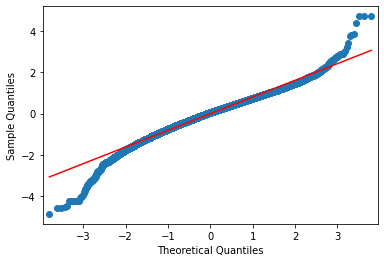

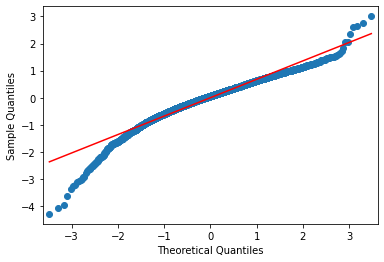

In [195]:
sm.qqplot(res.resid, line = "s")
sm.qqplot(res_tv.resid, line = "s")
plt.show()

Omnibus suggests that the residuals are distributed abnormally, but the sample is quite large, so it is not surprising. If you look at the graphs, it's not that bad, except for outliers on both sides.

### Describe the main conclusions after building the regression model

If we try to draw conclusions based on the constructed regression, we can assess what affects the final score from the audience.

Depending on the age rating of the anime, its rating differs - those titles with a rating of 13+ and 17+ increase the rating, however, the content "for an adult audience" rather lowers it, i.e. the anime in this case is not very successful.

The original source from which the anime was created also contributes to the target variable. Judging by the final model, those anime that are based on manga and short stories are more successful than others. Interestingly, in the case of TV-anime, the primary source in the form of a book betrays their success, while if you look at the entire animation as a whole and take into account full-length anime, OVA and others, the anime is rated lower.

Regarding genres, anime is highly appreciated if it contains genre of sports, adventure, drama, shonen (designed for boys and boys aged 12 to 18 years) and shojo (designed for girls of the same age). Thrillers and slice-of-life anime also perform well, which cannot be said about horror films and the genre of "cars". Fun fact: in the case of TV-show animes, the genre "for adults" has almost no effect on the rating, while in general such an anime will be rated worse, all other things being equal (but in general there is no stat. significance, so let's not dwell on it).

Numerical predictors do not have much effect on the estimate.